# Hardware-friendly Approximations for the Sigmoid Function

The sigmoid function is one of the most widely used activation functions in neural networks. It is typically defined as

$
\begin{align}
\sigma(x) = \frac{{1}}{{1 + e^{{-x}}}} \quad \text{(Standard Definition)}
\end{align}
$

Or equivalently

$
\begin{align}
\sigma(x) = \frac{e^x}{e^x + 1} \quad \text{(Inverted Definition)}
\end{align}
$

<div style="display: flex; justify-content: center; align-items: center;">
<img src="img/sigmoid.png" width="600"/>
</div>

The sigmoid function has a few notable properties:
- Symmetry around 0: $\sigma(-x) = 1 - \sigma(x)$
- Bounded: $\sigma(x) \in (0, 1) \quad \forall x \in \mathbb{R}$
- Strictly-increasing
- Practically constant for larger values of |x|. We'll be making the following assumptions:
  - $\sigma(x) \approx 0.999 \dots 9  \quad \forall x > 6$
  - $\sigma(x) \approx 0.000 \dots 1 \quad \forall x < -6$

Our goal is to develop approximations of the sigmoid function for implementation on ML acceleration hardware. We'll focus on 2 particular floating-point formats:
- Single-precision (CPUs, GPUs, general-purpose ML accelerators)
- bfloat16 (Most common in GPUs and ML inference hardware)

In the end, we'll implement a 

## Evaluated Methods

We'll evaluate several approaches for implementing the sigmoid function, loosely ordered from least to most sophisticated:

## 1. Via the formulae above
The most straightforward way of calculating the function is via its definition: $\sigma(x) = \frac{{1}}{{1 + e^{{-x}}}}$

If this were ideal, however, we wouldn't need to spend all this time coming up with good approximations for it:
- Pros:
  - Good accuracy-wise
- Cons:
  - Floating-point division and exponentiation are slow and require large amounts of logic to implement in hardware
  - They're also complicated to implement, which is problematic when not using vendor IP or a pre-made implementation
  - Resulting design would be slow, power-hungry, and large, limiting how many sigmoid units we can fit on a single chip.

## 2. Via the formulae above, approximating $e^x$ with Taylor expansion
To avoid the exponential, one might consider replacing $e^x^ with its Taylor expansion: $e^x = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \frac{x^4}{4!} + \dots$

Regrettably, this is not a great way of implementing the function. In fact, it's arguably worse than doing it the "obvious" way:
- Pros:
  - (Blank)
- Cons:
  - Inaccurate for larger values of x, unless the Taylor expansion uses a really high order (~15 terms or so)
  - Taylor expansion needs too many cycles and logic to compute
  - Still requires an expensive floating-point division, in addition to an overwhelming amount of additions/multiplications
  - Design is even larger and more power-hungry than the first one

## 3. Via a branchless, exponential-less approximation
A commonly cited fast approximation for the sigmoid function is
$
\begin{align}
\sigma(x) = 0.5 * (\frac{x}{1 + |x|} + 1)
\end{align}
$

This approximation comes with some interesting ups and downs:
- Pros:
  - Branchless, very friendly to SIMD hardware (CPUs, GPUs)
  - Simpler to implement in hardware, comparatively low logic usage
- Cons:
  - Division remains an issue
  - Inaccurate for many inputs, making it unsuitable for many ML tasks, especially for training

## 4. Via a piecewise, exponential-less approximation
Based on the third method, we started looking for approximations with the general form

$
\begin{align}
σ(x) = a * (\frac{bx}{c + d|x|} + e)
\end{align}
$

Where $a, b, c, d, e$ are parameters chosen based on the input value. In this experiment, we trained these parameters using Pytorch, by representing our problem as a neural network layer. We trained 4 sets of parameters {a, b, c, d, e}, to be used when |x| < 1, |x| < 2, |x| < 4, and |x| < 6 respectively. We assume that for large values (x > 6) the result saturates close to 1, while for small values (x < - 6) it saturates close to 0.

- Pros:
  - Very accurate with proper parameter tuning
  - Simpler to implement in hardware, comparatively low logic usage
- Cons:
  - Division remains problematic
- Thoughts:
  - Branching makes it unfit for SIMD CPU/GPU implementation. Not particularly a problem for us, since we're making our own RTL design.

## 5. Via a piecewise, polynomial approximation
Improving on the fourth method, we want to look for division-free approximations. We start looking for approximations in polynomial form, where the polynomial coefficients will be similarly trained via Pytorch and chosen based on the value of the input.

$
\begin{align}
σ(x) = a_0 + a_1 x + a_2 x^2 + \dots + a_N x^N
\end{align}
$

While this gave us a good approximation for small values of x, larger values of x tended to blow up. Thus, we added an offset term that ensures the powers calculated by our polynomial stay relatively small and don't blow up.

$
\begin{align}
σ(x) = a_0 + a_1 (x - \text{offset}) + a_2 (x - \text{offset})^2 + \dots + a_N (x - \text{offset})^N
\end{align}
$

We also find, experimentally, that a 2nd order polynomial can approximate the function very well, thus we settle on N = 2 (2nd order polynomial):

$
\begin{align}
σ(x) = a_0 + a_1 (x - \text{offset}) + a_2 (x - \text{offset})^2
\end{align}
$

This is the approximation we decided to implement in our bfloat16 accelerator design, using 6 different sets of parameters {$a_0, a_1, a_2$}.
- Pros:
    - Very accurate with proper parameter tuning
    - Very friendly to pipelined hardware designs
    - Simple to implement comparatively low logic usage
    - Made up entirely of addition, multiplication, and multiply-add operations, all of which can be implemented very efficiently in hardware (Using FPGA DSP slices, fast dedicated multipliers, fused multiply-add units, ...)
- Thoughts:
  - Can we achieve even lower logic usage?

## 6. Via a lookup table (LUT)
We can store a lookup table of precomputed sigmoid values (eg 128 values uniformly distributed between -6.0 and +6.0). For a given input, we'll read the LUT entries that correspond to the 2 numbers closest to the input. Then, we just need to interpolate between these 2 entries, based on how close the input value is to each of the 2 numbers.

- Pros:
  - Very accurate, even for small values of N
  - Very friendly to pipelined hardware designs
  - Simple to implement
  - Very low logic usage, a multiplier and a few adders are adequate for performing interpolation
- Thoughts:
  - Takes up more memory than the polynomial approach
  - May perform worse than the polynomial approach in some cases (Eg fused-kernel networks running on GPU under bad cache locality conditions)

In [ ]:
# Set up libraries
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [ ]:
# Converts f32 values to torch.bfloat16 tensors (Python doesn't have native bf16 support)
def bf16(value):
    return torch.Tensor([value]).to(torch.bfloat16)

# Taylor series-based implementation for exp(x)
def taylor_exp(x, order):
    sum = np.ones_like(x) # 0th order term
    pow = np.ones_like(x)
    factorial = 1
    
    for i in range(1, order + 1):
        pow *= x
        factorial *= i
        sum += (pow / factorial)
    return sum

def plot(x, y, title = ""):
    plt.plot(x, y)
    plt.title(title)
    # Should intersect with sigmoid graph at x = 0
    plt.axhline(y = 0.5, color = "r", linestyle = "--", label = "y = 0.5")

    plt.xlabel("x")
    plt.ylabel("σ(x)")
    plt.grid()
    plt.show()

Comparison between np.exp and Taylor series-based implementation of exp(x)

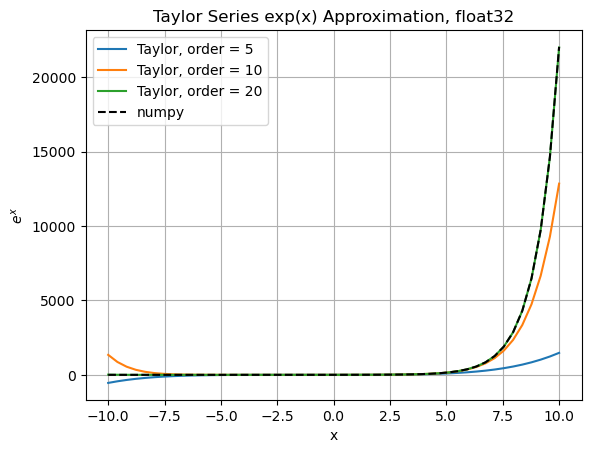

In [3]:
x = np.linspace(-10, 10)

plt.plot(x, taylor_exp(x, order = 5), label = "Taylor, order = 5")
plt.plot(x, taylor_exp(x, order = 10), label = "Taylor, order = 10")
plt.plot(x, taylor_exp(x, order = 20), label = "Taylor, order = 20")
plt.plot(x, np.exp(x), label = "numpy", linestyle = "--", color = "black")

plt.legend()
plt.xlabel("x")
plt.ylabel("$e^x$")
plt.title("Taylor Series exp(x) Approximation, float32")
plt.grid(True)
plt.show()


/var/folders/kq/4l68ssdn21l03yw5vp7yn0dh0000gn/T/ipykernel_23106/315483838.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.Tensor([value]).to(torch.bfloat16)


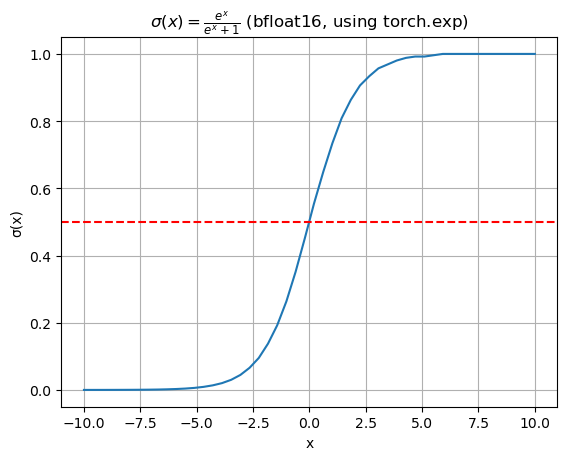

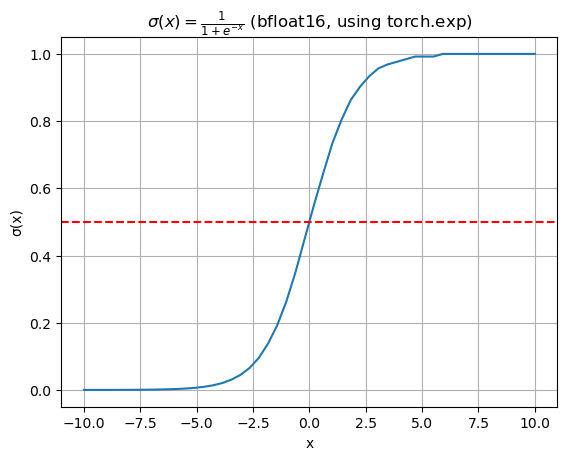

In [4]:
# If inverseDefinition is False, calculate sigmoid as
#     σ(x) = 1 / (1 + exp(-x))
# Else if inverseDefinition is True, calculate sigmoid as:
#     σ(x) = exp(x) / (1 + exp(x))
def sigmoid_bf16_torch(x, invertedDefinition = False):
    if invertedDefinition:
        exp = torch.exp(bf16(x))
        return exp / (exp + bf16(1.0))
    else:
        exp = torch.exp(bf16(-x))
        return bf16(1.0) / (bf16(1.0) + exp)

x = np.linspace(-10, 10)
y1 = sigmoid_bf16_torch(x, invertedDefinition = True).to(torch.float32).numpy().flatten()
y2 = sigmoid_bf16_torch(x, invertedDefinition = False).to(torch.float32).numpy().flatten()

plot(x, y1, f"$\\sigma(x) = \\frac{{e^x}}{{e^x + 1}}$ (bfloat16, using torch.exp)")
plot(x, y2, f"$\\sigma(x) = \\frac{{1}}{{1 + e^{{-x}}}}$ (bfloat16, using torch.exp)")

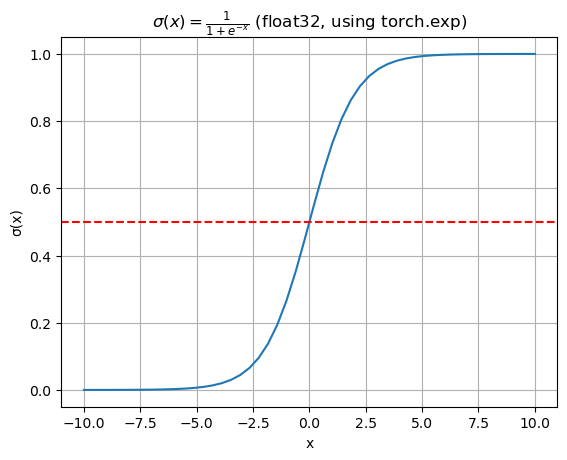

In [5]:
def sigmoid_f32_torch(x):
    exp = torch.exp(-x)
    return 1.0 / (1.0 + exp)

x = np.linspace(-10, 10)
y = sigmoid_f32_torch(torch.Tensor(x)).numpy().flatten()

plot(x, y, f"$\\sigma(x) = \\frac{{1}}{{1 + e^{{-x}}}}$ (float32, using torch.exp)")

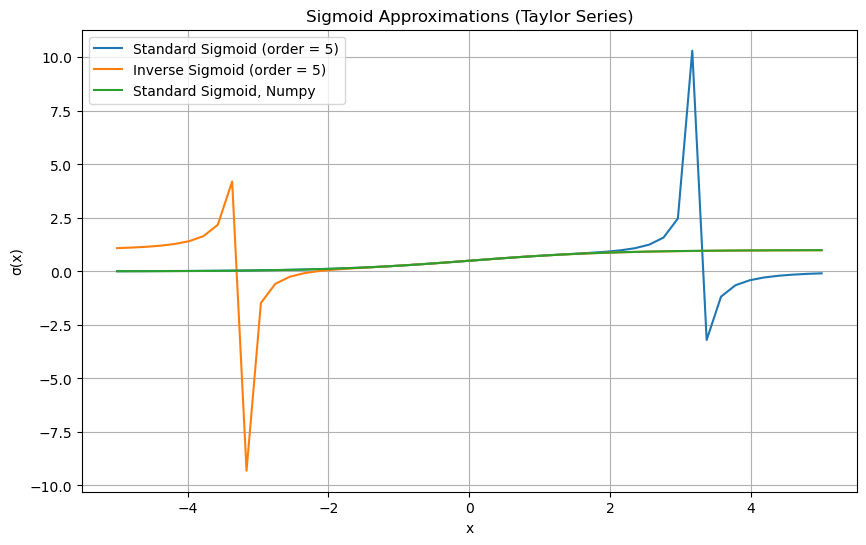

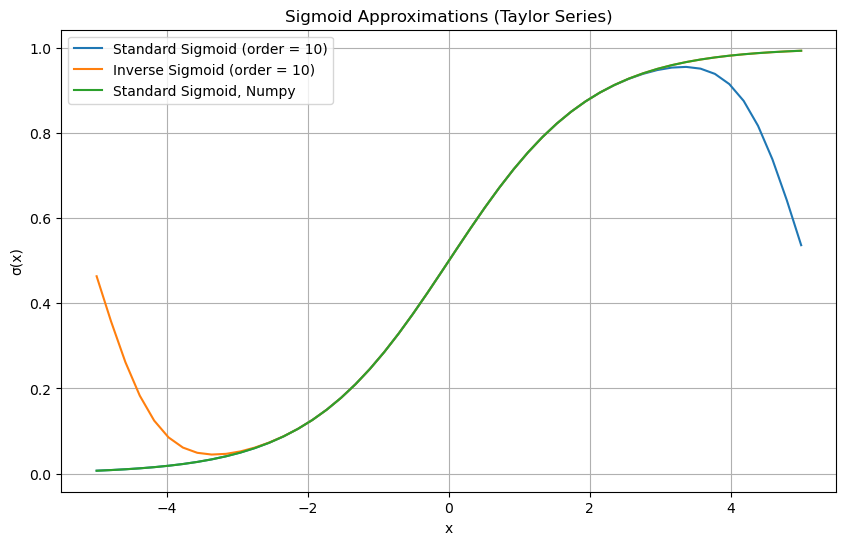

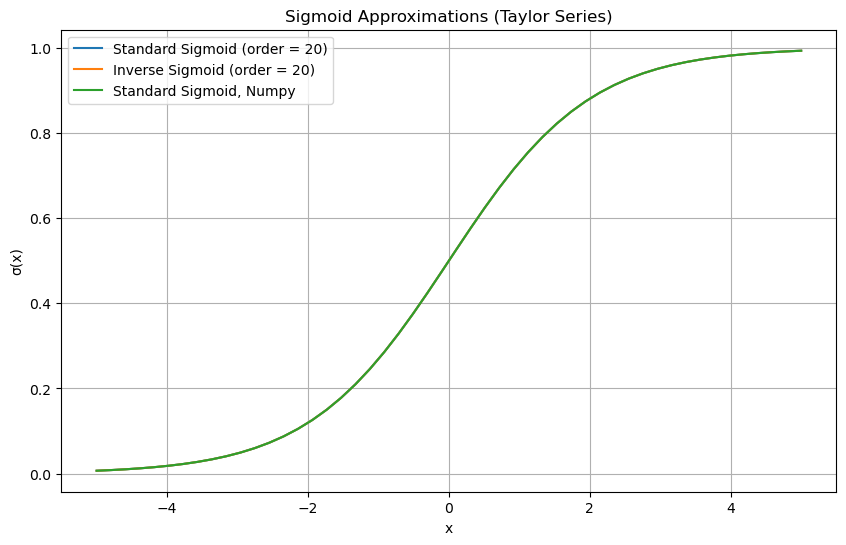

In [6]:
# If inverseDefinition is False, calculate sigmoid as
#     σ(x) = 1 / (1 + exp(-x))
# Else if inverseDefinition is True, calculate sigmoid as:
#     σ(x) = exp(x) / (1 + exp(x))
def sigmoid_f32_taylor_exp(x, order, inverseDefinition = False):
    if inverseDefinition:
        exp = taylor_exp(x, order)
        return exp / (exp + 1.0)
    else:
        exp = taylor_exp(-x, order)
        return 1.0 / (1.0 + exp)

x = np.linspace(-5, 5)

def compareTaylorSeries(order = 20):
    plt.figure(figsize = (10, 6))

    y = sigmoid_f32_taylor_exp(x, order = order, inverseDefinition = False)
    plt.plot(x, y, label = f"Standard Sigmoid (order = {order})")

    y = sigmoid_f32_taylor_exp(x, order = order, inverseDefinition = True)
    plt.plot(x, y, label = f"Inverse Sigmoid (order = {order})")

    y = 1.0 / (1.0 + np.exp(-x))
    plt.plot(x, y, label = f"Standard Sigmoid, Numpy")

    plt.xlabel("x")
    plt.ylabel("σ(x)")
    plt.title("Sigmoid Approximations (Taylor Series)")
    plt.grid(True)
    plt.legend()
    plt.show()

compareTaylorSeries(order = 5)
compareTaylorSeries(order = 10)
compareTaylorSeries(order = 20)

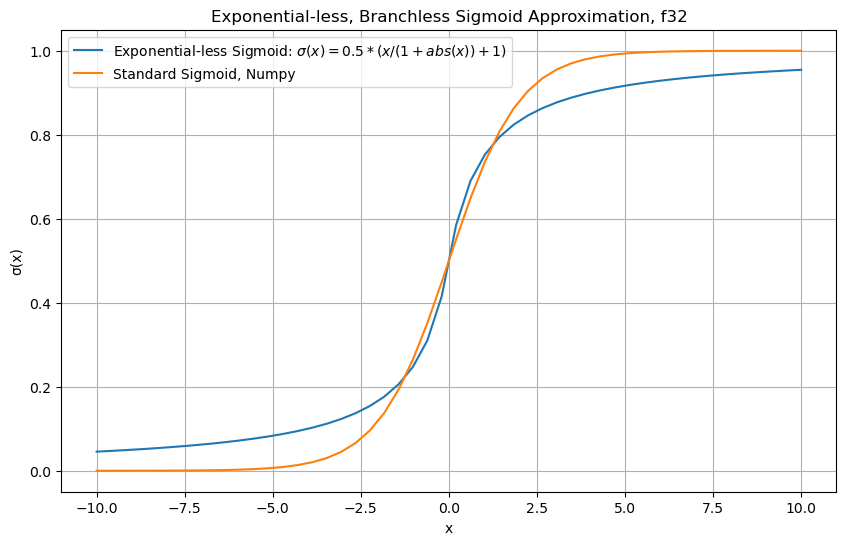

In [7]:
# Exponential-less, branchless sigmoid approximation (https://stackoverflow.com/a/10733861)
def fast_sigmoid(x):
    return 0.5 * (x / (1 + np.abs(x)) + 1) 

# Exponential-less, branchless tanh approximation (https://stackoverflow.com/a/10733861)
def fast_tanh(x):
    return x / (1 + np.abs(x))

plt.figure(figsize = (10, 6))

x = np.linspace(-10, 10)
y = fast_sigmoid(x)
plt.plot(x, y, label = "Exponential-less Sigmoid: $\\sigma(x) = 0.5 * (x / (1 + abs(x)) + 1)$")

y = 1.0 / (1.0 + np.exp(-x))
plt.plot(x, y, label = "Standard Sigmoid, Numpy")

plt.xlabel("x")
plt.ylabel("σ(x)")
plt.title("Exponential-less, Branchless Sigmoid Approximation, f32")
plt.grid(True)
plt.legend()
plt.show()


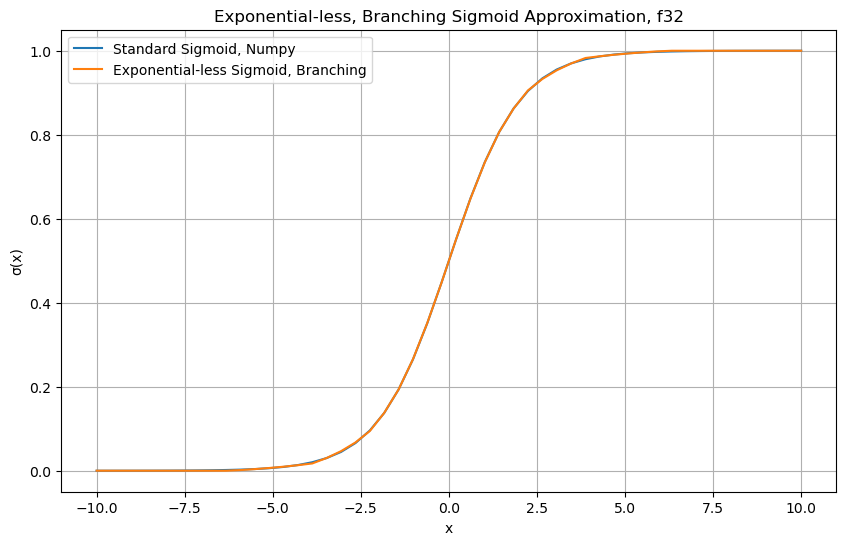

In [8]:
# Generalization of the above branchless sigmoid function.
# Used to compute the sigmoid function, with different parameters (a, b, c, d, e) based on the value of x
# General formula:
# σ(x) = a * (b * x / (c + d * np.abs(x)) + e), where x in [lower bound, upper bound]
# Since the sigmoid function is symmetric, ie σ(-x) = 1 - σ(x), we can simply approximate the function for values >= 0
# And use the above property to calculate it for negative values
# Thus the formula becomes:
# σ(x) = a * (b * x / (c + d * x) + e), where x in [lower bound, upper bound]
def parametric_sigmoid(x, a, b, c, d, e):
    return a * (b * x / (c + d * x) + e)

# Exponential-less, branchful approximation of sigmoid function
def fast_sigmoid_branching(x_vec):
    output = np.empty_like(x_vec)
    
    for i, x in enumerate(x_vec):
        # Sigmoid is symmetrical around 0. Calculate sigmoid on abs(x), then flip it accordingly if it was negaitve
        x_abs = np.abs(x)
        y = 0

        if x_abs < 1:
            y = parametric_sigmoid(x_abs, 1.03925, 0.2839, 1.1252, 0.1417, 0.4800)
        elif x_abs < 2:
            y = parametric_sigmoid(x_abs, -0.3460, -0.6023, 0.4117, 0.2342, -1.1782)
        elif x_abs < 4:
            y = parametric_sigmoid(x_abs, -1.4539, 0.8033, -0.2292, -0.7260, 0.3473)
        elif x_abs < 6:
            y = parametric_sigmoid(x_abs, 0.2892, 0.8950, 0.0413, 0.2349, -0.2479)
        else:
            y = 0.9999

        # If x < 0, σ(x) = 1 - σ(|x|) due to sigmoid symmetry
        if x < 0:
            y = 1 - y
        output[i] = y
    return output

plt.figure(figsize = (10, 6))

y = 1.0 / (1.0 + np.exp(-x))
plt.plot(x, y, label = "Standard Sigmoid, Numpy")

y = fast_sigmoid_branching(x)
plt.plot(x, y, label = "Exponential-less Sigmoid, Branching")

plt.xlabel("x")
plt.ylabel("σ(x)")
plt.title("Exponential-less, Branching Sigmoid Approximation, f32")
plt.grid(True)
plt.legend()
plt.show()


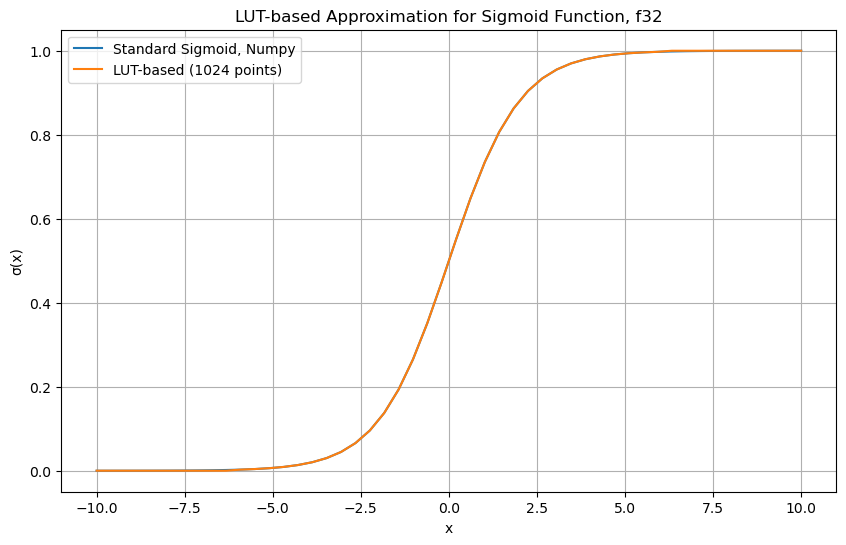

In [ ]:
def create_sigmoid_lut(size):
    lut = np.zeros(size)

    for i in range(size):
        # Mapping index to x value, in [0, 6] range
        # e.g., 0 -> 0, ...,  size-1 -> 6
        x = 6 * i / (size - 1)
        lut[i] = 1.0 / (1.0 + np.exp(-x))
    return lut

def sigmoid_lut_based_single(x, lut, size):
    minVal = 0  # Minimum value of LUT range
    maxVal = 6   # Maximum value of LUT range

    # Our LUT only contains values from 0 to 6, to save space
    # If x < 0, compute it as σ(x) = 1 - σ(|x|)
    if (x < 0):
        return 1.0 - sigmoid_lut_based_single(-x, lut, size)
    
    elif (x > maxVal):
        return 0.9999
    
    idx = (x - minVal) * (size - 1) / (maxVal - minVal)

    # Get two closest indices in the LUT
    idxLow = int(np.floor(idx))
    idxHigh = int(np.ceil(idx))
    
    # If x is right on top of one of the LUT points
    if idxLow == idxHigh:
        return lut[idxLow]
    
    # Otherwise, get the fractional part and interpolate between the 2 values
    t = idx - idxLow
    return lut[idxLow] + (lut[idxHigh] - lut[idxLow]) * t

def sigmoid_lut_based(x_vec, lut, size):
    output = np.empty_like(x_vec)
    
    for i, x in enumerate(x_vec):
        output[i] = sigmoid_lut_based_single(x, lut, size)
    return output

lutSize = 1024
lut = create_sigmoid_lut(size = lutSize)
plt.figure(figsize = (10, 6))

y = 1.0 / (1.0 + np.exp(-x))
plt.plot(x, y, label = "Standard Sigmoid, Numpy")

y = sigmoid_lut_based(x, lut, lutSize)
plt.plot(x, y, label = f"LUT-based ({lutSize} points)")

plt.xlabel("x")
plt.ylabel("σ(x)")
plt.title("LUT-based Approximation for Sigmoid Function, f32")
plt.grid(True)
plt.legend()
plt.show()

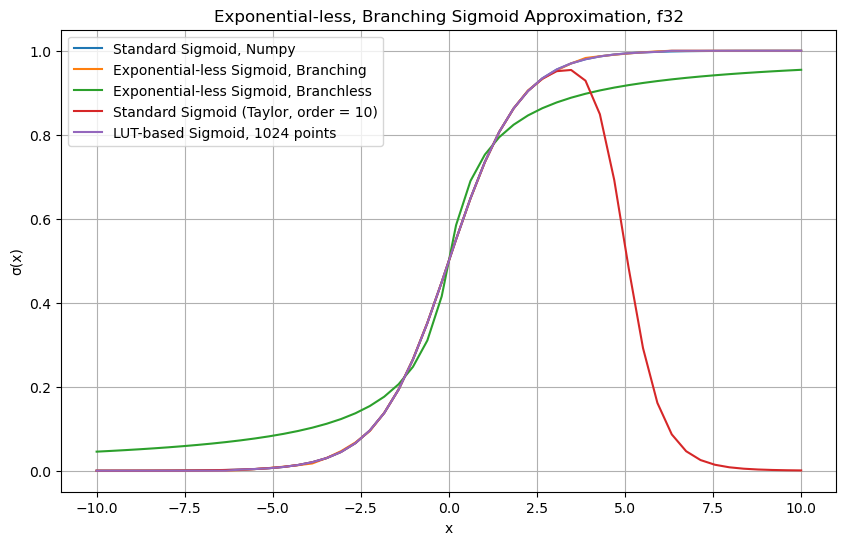

In [10]:
plt.figure(figsize = (10, 6))

y = 1.0 / (1.0 + np.exp(-x))
plt.plot(x, y, label = "Standard Sigmoid, Numpy")

y = fast_sigmoid_branching(x)
plt.plot(x, y, label = "Exponential-less Sigmoid, Branching")

y = fast_sigmoid(x)
plt.plot(x, y, label = "Exponential-less Sigmoid, Branchless")

order = 10
y = sigmoid_f32_taylor_exp(x, order = order, inverseDefinition = False)
plt.plot(x, y, label = f"Standard Sigmoid (Taylor, order = {order})")

y = sigmoid_lut_based(x, lut, lutSize)
plt.plot(x, y, label = f"LUT-based Sigmoid, {lutSize} points")

plt.xlabel("x")
plt.ylabel("σ(x)")
plt.title("Exponential-less, Branching Sigmoid Approximation, f32")
plt.grid(True)
plt.legend()
plt.show()


Squared error in LUT vs Exponential-less, branching algorithm:

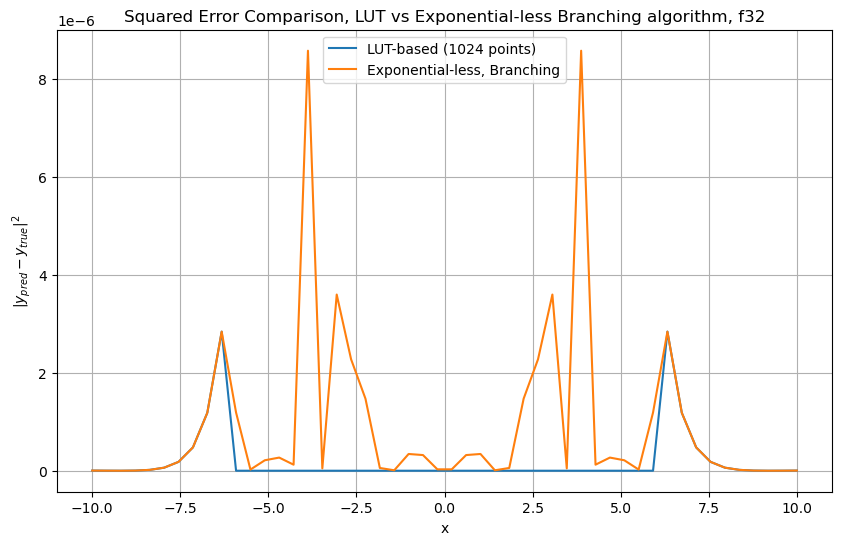

In [11]:
y = 1.0 / (1.0 + np.exp(-x))

error_lut = np.square(y - sigmoid_lut_based(x, lut, lutSize))
error_fast_branching = np.square(y - fast_sigmoid_branching(x))

plt.figure(figsize = (10, 6))
plt.plot(x, error_lut, label = f"LUT-based ({lutSize} points)")
plt.plot(x, error_fast_branching, label = "Exponential-less, Branching")

plt.xlabel("x")
plt.ylabel("$|y_{pred} - y_{true}|^2$")
plt.title("Squared Error Comparison, LUT vs Exponential-less Branching algorithm, f32")
plt.grid(True)
plt.legend()
plt.show()

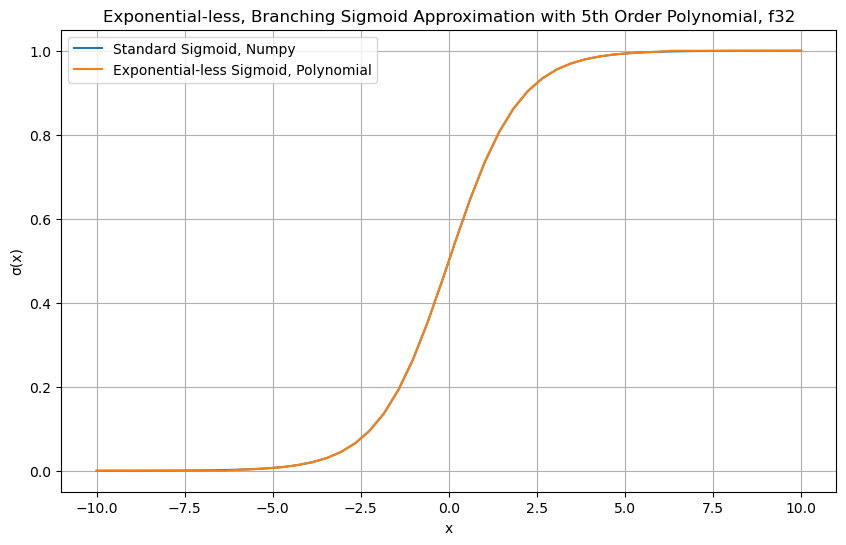

In [12]:
def polynomial_sigmoid(x, coefficients, offset):
    y = coefficients[0]
    x_power = np.ones_like(x)
    x_multiplier = x - np.broadcast_to(offset, x.shape)

    for i in range(1, len(coefficients)):
        x_power *= x_multiplier
        y = y + x_power * coefficients[i]
    return y

# Exponential-less, branchful approximation of sigmoid function
def sigmoid_branching_polynomial(x_vec):
    output = np.empty_like(x_vec)
    
    for i, x in enumerate(x_vec):
        # Sigmoid is symmetrical around 0. Calculate sigmoid on abs(x), then flip it accordingly if it was negaitve
        x_abs = np.abs(x)
        y = 0

        if x_abs < 1:
            y = polynomial_sigmoid(x_abs, [0.5010008, 0.22136687, 0.19342738, -0.5231247, 0.5537795, -0.21612851], 0)
        elif x_abs < 2:
            y = polynomial_sigmoid(x_abs, [0.7320988, 0.16688538, 0.15533534, -0.5270234, 0.57939947, -0.22665948], 1)
        elif x_abs < 3:
            y = polynomial_sigmoid(x_abs, [0.88158137, 0.08256347, 0.11147195, -0.3865234, 0.433558, -0.17065544], 2)
        elif x_abs < 4:
            y = polynomial_sigmoid(x_abs, [0.95209116, 0.05905316, -0.1141415, 0.24869199, -0.26870516, 0.10539465], 3)
        elif x_abs < 5:
            y = polynomial_sigmoid(x_abs, [0.9812842, 0.04014706, -0.1599278, 0.3958077, -0.43351972, 0.17042148], 4)
        elif x_abs < 6:
            y = polynomial_sigmoid(x_abs, [0.99375355, -0.0061026, 0.08283123, -0.2224306, 0.24593456, -0.09678433], 5)
        else:
            y = 0.9999

        # If x < 0, σ(x) = 1 - σ(|x|) due to sigmoid symmetry
        if x < 0:
            y = 1 - y
        output[i] = y
    return output

plt.figure(figsize = (10, 6))

y = 1.0 / (1.0 + np.exp(-x))
plt.plot(x, y, label = "Standard Sigmoid, Numpy")

y = sigmoid_branching_polynomial(x)
plt.plot(x, y, label = "Exponential-less Sigmoid, Polynomial")

plt.xlabel("x")
plt.ylabel("σ(x)")
plt.title("Exponential-less, Branching Sigmoid Approximation with 5th Order Polynomial, f32")
plt.grid(True)
plt.legend()
plt.show()


In the end, we implemented a hardware-based bfloat16 accelerator for the sigmoid function, using a 2nd-order polynomial approximation we trained with pytorch. Below, we compare its accuracy with a regular f32 implementation of the function using numpy, for 100 values uniformly distributed between -10 and +10.

We can see that our design, while slightly inaccurate due to limitedn bfloat16 precision, is more than accurate enough for use in regular ML inference tasks.

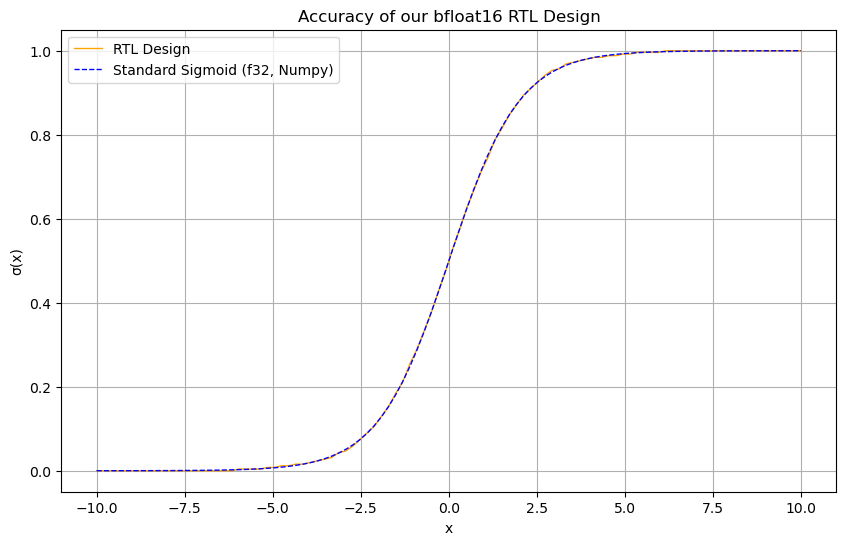

In [ ]:
import os
from rtl_testbench import RTLTestbench

filePath = "testbench_results/rtl_testbench_outputs.txt"

if os.path.exists(filePath):
    x = np.linspace(-10, 10, num = 100)

    plt.figure(figsize = (10, 6))

    y = RTLTestbench.parseOutput(filePath)
    plt.plot(x, y, label = "RTL Design (2nd order polynomial)", color = "orange", linewidth = 1)

    y = 1.0 / (1.0 + np.exp(-x))
    plt.plot(x, y, label = "Standard Sigmoid (f32, Numpy)", linestyle = "--", color = "blue", linewidth = 1)

    plt.xlabel("x")
    plt.ylabel("σ(x)")
    plt.title("Accuracy of our bfloat16 RTL Design")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No output file from our RTL design found. Please run the RTL testbench, copy the results and try again")
    print("Skipping cell :(")